In [1]:
#importing the required libraries
import numpy as np
import pandas as pd
import pickle
#import matrix_factorization 
import scipy.sparse as sp
from scipy.sparse.linalg import svds

In [2]:
#pip install scipy

In [3]:
#read in the ratings data
ratings = pd.read_csv("C:/Users/valen/OneDrive/Documents/ratings_small.csv")

In [4]:
len(ratings)

100004

In [5]:
#only takig three columns userId, movieID and rating into the df
ratings = ratings[['userId', 'movieId','rating']]

In [6]:
#need to check if the user has multiple ratings for a movie because if so we can just condense them to be the max
#using np.max
ratings

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0
...,...,...,...
99999,671,6268,2.5
100000,671,6269,4.0
100001,671,6365,4.0
100002,671,6385,2.5


In [7]:
#need to check if the user has multiple ratings for a movie because if so we can just condense them to be the max
#using np.max
ratings_df = ratings.groupby(['userId','movieId']).aggregate(np.max)

In [8]:
#lets print out the length to see if there were any changes, ofcourse it will be left after aggregating
len(ratings_df)

100004

In [9]:
#we see that the length is the same as before, so no user has made a review more than once on a movie
#lets move on in inspecting the ratings data a bit further

In [10]:
#first five
ratings.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [11]:
ratings_df.head()

rating
userId movieId        
1      31          2.5
       1029        3.0
       1061        3.0
       1129        2.0
       1172        4.0

In [12]:
#see how many unique ids there are 
len(ratings['userId'].unique())

671

In [13]:
#get the percentage of each rating value
#first get the number of each rating and then divide by the total
count_ratings = ratings.groupby('rating').count()
#create a new column per_total 
count_ratings['per_total']=round(count_ratings['userId']*100/count_ratings['userId'].sum(),1)

In [14]:
count_ratings

,userId,movieId,per_total
rating,,,
0.5,1101,1101,1.1
1.0,3326,3326,3.3
1.5,1687,1687,1.7
2.0,7271,7271,7.3
2.5,4449,4449,4.4
3.0,20064,20064,20.1
3.5,10538,10538,10.5
4.0,28750,28750,28.7
4.5,7723,7723,7.7


<AxesSubplot:xlabel='rating'>

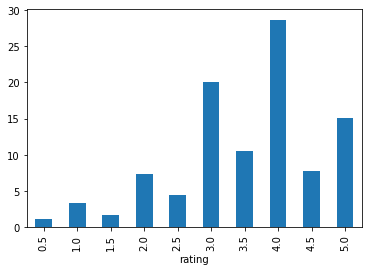

In [15]:
#use ply plot.bar the to visualize the per total using a bar graph
count_ratings['per_total'].plot.bar()

In [16]:
#now lets read in the movies dataset
movie_list = pd.read_csv("C:/Users/valen/OneDrive/Documents/movies.csv")

In [17]:
len(movie_list)

9742

In [18]:
#lets see the file
movie_list.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [19]:
#no lets read the tags intnto tags df 
tags = pd.read_csv("C:/Users/valen/OneDrive/Documents/tags.csv")

In [20]:
#lets see the file
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [21]:
#create a genres_df of the column genres from the movie_list df
genres = movie_list['genres']

In [22]:
genres.head()

0    Adventure|Animation|Children|Comedy|Fantasy
1                     Adventure|Children|Fantasy
2                                 Comedy|Romance
3                           Comedy|Drama|Romance
4                                         Comedy
Name: genres, dtype: object

In [23]:
#cleaning
#we see that the genres are formatted using | to sepearate the generes so we will split the genres from them and create
#a new list based on the split genres into new_list and then remove the blank 

In [24]:
genre_list = ""
for index,row in movie_list.iterrows():
        genre_list += row.genres + "|"
#split the string into a list of values
genre_list_split = genre_list.split('|')
#de-duplicate values
new_list = list(set(genre_list_split))
#remove the value that is blank
new_list.remove('')
#let's see it now
new_list

['Horror',
 'Musical',
 'Animation',
 '(no genres listed)',
 'Crime',
 'Fantasy',
 'Documentary',
 'Adventure',
 'Romance',
 'Western',
 'Comedy',
 'Mystery',
 'IMAX',
 'Drama',
 'Children',
 'Film-Noir',
 'Action',
 'War',
 'Sci-Fi',
 'Thriller']

In [25]:
#lets add the generes into their own columns using .copy on the movie_list
movies_with_genres = movie_list.copy()

In [26]:
for genre in new_list :
    movies_with_genres[genre] = movies_with_genres.apply(lambda _:int(genre in _.genres), axis = 1)

movies_with_genres.head() #df with new columns with generes

,movieId,title,genres,Horror,Musical,Animation,(no genres listed),Crime,Fantasy,Documentary,...,Comedy,Mystery,IMAX,Drama,Children,Film-Noir,Action,War,Sci-Fi,Thriller
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [27]:
#lets check the sparisty by taking the length of the ratings divided by the unique no of users and number of movies
num_users = len(ratings['userId'].unique())
num_movies = len(ratings['movieId'].unique())

In [28]:
sparsity = round(1.0 - len(ratings)/(1.0*(num_movies*num_users)),3)
print(sparsity)

0.984


In [29]:
#count the number of unique elements in movieID
len(ratings['movieId'].unique())

9066

In [30]:
#now we will find the average rating for a movie and then the number of ratings for each movie 
#so can use aggregate function .agg for the average/mean of a rating and the count
avg_movie_rating = pd.DataFrame(ratings.groupby('movieId')['rating'].agg(['mean','count']))

In [31]:
# avg_movie_rating['movieId']= avg_movie_rating.index

In [32]:
#lets see
avg_movie_rating.head()

,mean,count
movieId,,
1,3.872470,247
2,3.401869,107
3,3.161017,59
4,2.384615,13
5,3.267857,56


In [33]:
len(avg_movie_rating)

9066

In [34]:
#calculate the percentile count
np.percentile(avg_movie_rating['count'],60)

4.0

In [35]:
#the average movie rating for all movies 
avg_rating_all=ratings['rating'].mean()
avg_rating_all

3.543608255669773

In [36]:
#set a minimum threshold for number of reviews that the movie has to have
min_reviews=30 #30 is reasonable
min_reviews

30

In [37]:
movie_score = avg_movie_rating.loc[avg_movie_rating['count']>min_reviews]
movie_score.head()

,mean,count
movieId,,
1,3.872470,247
2,3.401869,107
3,3.161017,59
5,3.267857,56
6,3.884615,104


In [38]:
len(movie_score)

821

In [39]:
#create a function for weighted rating score based off the count of reviews
def weighted_rating(x, m=min_reviews, C=avg_rating_all):
    v = x['count']
    R = x['mean']
    # formula based on the IMDB formula 
    #= votes/cotes + minimum votes required to be on top 50 * average of the movie so the mean, ratings
    # + the minm votes / minm votes + votes * the mean votes acorss the whole
    
    return (v/(v+m) * R) + (m/(m+v) * C)

In [40]:
#now we should calculate the weighted score for each movie
movie_score['weighted_score'] = movie_score.apply(weighted_rating, axis=1)
movie_score.head()

C:\Users\valen\AppData\Local\Temp/ipykernel_37136/461682848.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_score['weighted_score'] = movie_score.apply(weighted_rating, axis=1)


,mean,count,weighted_score
movieId,,,
1,3.872470,247,3.836853
2,3.401869,107,3.432907
3,3.161017,59,3.289980
5,3.267857,56,3.364049
6,3.884615,104,3.808271


In [41]:
#join movie details to movie ratings
movies_with_genres.index.name = None #.drop(columns=[])#, axis = 1)
movies_with_genres = movies_with_genres.rename_axis(None) 
movie_score = pd.merge(movie_score,movies_with_genres,on='movieId')
#movie_score = movie_score.index.name = NULL
#join movie links to movie ratings
#movie_score = pd.merge(movie_score,links,on='movieId')
movie_score.head()

,movieId,mean,count,weighted_score,title,genres,Horror,Musical,Animation,(no genres listed),...,Comedy,Mystery,IMAX,Drama,Children,Film-Noir,Action,War,Sci-Fi,Thriller
0,1,3.872470,247,3.836853,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0
1,2,3.401869,107,3.432907,Jumanji (1995),Adventure|Children|Fantasy,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,3,3.161017,59,3.289980,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,5,3.267857,56,3.364049,Father of the Bride Part II (1995),Comedy,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,6,3.884615,104,3.808271,Heat (1995),Action|Crime|Thriller,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [42]:
#now lets list the top scored movies over the whole range of movies
pd.DataFrame(movie_score.sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score','genres']][:10])

,title,count,mean,weighted_score,genres
90,"Shawshank Redemption, The (1994)",311,4.487138,4.404130,Crime|Drama
196,"Godfather, The (1972)",200,4.487500,4.364384,Crime|Drama
26,"Usual Suspects, The (1995)",201,4.370647,4.263239,Crime|Mystery|Thriller
273,"Godfather: Part II, The (1974)",135,4.385185,4.232171,Crime|Drama
142,Schindler's List (1993),244,4.303279,4.220103,Drama|War
83,Pulp Fiction (1994),324,4.256173,4.195786,Comedy|Crime|Drama|Thriller
164,Fargo (1996),224,4.256696,4.172473,Comedy|Crime|Drama|Thriller
73,Star Wars: Episode IV - A New Hope (1977),291,4.221649,4.158281,Action|Adventure|Sci-Fi
255,Star Wars: Episode V - The Empire Strikes Back...,234,4.232906,4.154577,Action|Adventure|Sci-Fi
530,American Beauty (1999),220,4.236364,4.153233,Drama|Romance


In [43]:
#create best movies by genre based on weighted score which is calculated using IMDB formula we used above
def best_movies_by_genre(genre,top_n):
    return pd.DataFrame(movie_score.loc[(movie_score[genre]==1)].sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score']][:top_n])

In [142]:
movie_score.to_csv('movie_score.csv',index=False)

In [44]:
#call the function to return top recommended movies by genre, here musical
best_movies_by_genre('Musical',10)  

,title,count,mean,weighted_score
198,Singin' in the Rain (1952),64,4.195312,3.987322
208,"Wizard of Oz, The (1939)",117,3.957265,3.872845
291,Duck Soup (1933),34,4.132353,3.856379
223,"Sound of Music, The (1965)",80,3.943750,3.834620
398,West Side Story (1961),45,3.988889,3.810777
272,"Blues Brothers, The (1980)",94,3.893617,3.808937
106,"Lion King, The (1994)",200,3.777500,3.746992
756,Walk the Line (2005),42,3.880952,3.740392
220,Mary Poppins (1964),78,3.814103,3.738965
578,"Muppet Movie, The (1979)",35,3.900000,3.735512


In [45]:
#do the same, call function to return top recommended movies by genre, action
best_movies_by_genre('Action',10)  

,title,count,mean,weighted_score
73,Star Wars: Episode IV - A New Hope (1977),291,4.221649,4.158281
255,Star Wars: Episode V - The Empire Strikes Back...,234,4.232906,4.154577
494,"Matrix, The (1999)",259,4.183398,4.116984
257,Raiders of the Lost Ark (Indiana Jones and the...,220,4.193182,4.115233
256,"Princess Bride, The (1987)",163,4.208589,4.105224
787,"Dark Knight, The (2008)",121,4.235537,4.098068
543,Fight Club (1999),202,4.178218,4.096156
202,North by Northwest (1959),87,4.270115,4.083831
690,City of God (Cidade de Deus) (2002),69,4.297101,4.068770
713,"Lord of the Rings: The Return of the King, The...",176,4.127841,4.042758


In [46]:
#now call th efunction to return top recommended movies by genre, children
best_movies_by_genre('Children',10)  

,title,count,mean,weighted_score
180,Wallace & Gromit: A Close Shave (1995),62,4.193548,3.981611
214,It's a Wonderful Life (1946),72,4.152778,3.973610
248,Wallace & Gromit: The Wrong Trousers (1993),75,4.093333,3.936269
529,"Christmas Story, A (1983)",75,4.046667,3.902936
208,"Wizard of Oz, The (1939)",117,3.957265,3.872845
804,How to Train Your Dragon (2010),33,4.151515,3.862036
275,"Grand Day Out with Wallace and Gromit, A (1989)",39,4.089744,3.852293
805,Toy Story 3 (2010),42,4.071429,3.851503
0,Toy Story (1995),247,3.872470,3.836853
773,Ratatouille (2007),59,3.983051,3.834924


In [47]:
#run function to return top recommended movies by genre, drama
best_movies_by_genre('Drama',10)  

,title,count,mean,weighted_score
90,"Shawshank Redemption, The (1994)",311,4.487138,4.404130
196,"Godfather, The (1972)",200,4.487500,4.364384
273,"Godfather: Part II, The (1974)",135,4.385185,4.232171
142,Schindler's List (1993),244,4.303279,4.220103
83,Pulp Fiction (1994),324,4.256173,4.195786
164,Fargo (1996),224,4.256696,4.172473
530,American Beauty (1999),220,4.236364,4.153233
254,One Flew Over the Cuckoo's Nest (1975),144,4.256944,4.133955
787,"Dark Knight, The (2008)",121,4.235537,4.098068
543,Fight Club (1999),202,4.178218,4.096156


In [48]:
#lets create a data frame that contains the user ratings accross all movies in form of matrix used in matrix factorisation
ratings_df = pd.pivot_table(ratings, index='userId', columns='movieId', aggfunc=np.max)

In [49]:
#lets see it 
ratings_df.head()

rating                                                                 \
movieId 1      2      3      4      5      6      7      8      9      10       
userId                                                                          
1          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    4.0   
3          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    4.0   
5          NaN    NaN    4.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

         ...                                                                 \
movieId  ... 161084 161155 161594 161830 161918 161944 162376 162542 162672   
userId   ...                                                                  
1        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
5        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                
movieId 163949  
userId          
1          NaN  
2          NaN  
3          NaN  
4          NaN  
5          NaN  

[5 rows x 9066 columns]

In [50]:
#import matrix_factorization

In [51]:
#pip install matrix-factorization

In [52]:
#apply low rank matrix factorization to find the latent features 
#U, M = matrix_factorization.low_rank_matrix_factorization(ratings_df.as_matrix(),num_features=5,regularization_amount=1.0)

#lets proceed wihtout doing this

In [53]:
ratings_df

rating                                                                 \
movieId 1      2      3      4      5      6      7      8      9      10       
userId                                                                          
1          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    4.0   
3          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    4.0   
5          NaN    NaN    4.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...        ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
667        NaN    NaN    NaN    NaN    NaN    4.0    NaN    NaN    NaN    NaN   
668        NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
669        NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
670        4.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
671        5.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

         ...                                                                 \
movieId  ... 161084 161155 161594 161830 161918 161944 162376 162542 162672   
userId   ...                                                                  
1        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
5        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
667      ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
668      ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
669      ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
670      ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
671      ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                
movieId 163949  
userId          
1          NaN  
2          NaN  
3          NaN  
4          NaN  
5          NaN  
...        ...  
667        NaN  
668        NaN  
669        NaN  
670        NaN  
671        NaN  

[671 rows x 9066 columns]

In [54]:
#merging ratings and movies dataframes
ratings_movies = pd.merge(ratings,movie_list, on = 'movieId')

In [55]:
ratings_movies.head()

,userId,movieId,rating,title,genres
0,1,31,2.5,Dangerous Minds (1995),Drama
1,7,31,3.0,Dangerous Minds (1995),Drama
2,31,31,4.0,Dangerous Minds (1995),Drama
3,32,31,4.0,Dangerous Minds (1995),Drama
4,36,31,3.0,Dangerous Minds (1995),Drama


In [56]:
ratings_movies

,userId,movieId,rating,title,genres
0,1,31,2.5,Dangerous Minds (1995),Drama
1,7,31,3.0,Dangerous Minds (1995),Drama
2,31,31,4.0,Dangerous Minds (1995),Drama
3,32,31,4.0,Dangerous Minds (1995),Drama
4,36,31,3.0,Dangerous Minds (1995),Drama
...,...,...,...,...,...
97238,664,60832,3.0,Pathology (2008),Crime|Horror|Thriller
97239,664,64997,2.5,War of the Worlds (2005),Action|Sci-Fi
97240,665,129,3.0,Pie in the Sky (1996),Comedy|Romance
97241,665,4736,1.0,Summer Catch (2001),Comedy|Drama|Romance


In [57]:
#lets define a function that will return/show the other top ten movies which are watched by the people who saw this particular movie
def get_other_movies(movie_name):
    #get all users who watched a specific movie were title = user id
    df_movie_users_series = ratings_movies.loc[ratings_movies['title']==movie_name]['userId']
    #convert to a data frame
    df_movie_users = pd.DataFrame(df_movie_users_series,columns=['userId'])
    #now get a list of all other movies watched by these users
    other_movies = pd.merge(df_movie_users,ratings_movies,on='userId')
    #get a list of the most 'commonly' watched movies by these other user
    other_users_watched = pd.DataFrame(other_movies.groupby('title')['userId'].count()).sort_values('userId',ascending=False)
    #get the percentage of those who watched
    other_users_watched['per_who_watched'] = round(other_users_watched['userId']*100/other_users_watched['userId'][0],1)
    #return the top ten
    return other_users_watched[:10]

In [58]:
#lets try by getting other top ten movies which are watched by the people who saw 'Gone Girl'
get_other_movies('Gone Girl (2014)')

,userId,per_who_watched
title,,
Gone Girl (2014),25,100.0
Inception (2010),21,84.0
Forrest Gump (1994),19,76.0
"Dark Knight, The (2008)",18,72.0
Avatar (2009),17,68.0
Fight Club (1999),17,68.0
Shutter Island (2010),17,68.0
The Imitation Game (2014),16,64.0
"Monsters, Inc. (2001)",16,64.0


In [59]:
#now that we have it working, lets continue

In [60]:
from sklearn.neighbors import NearestNeighbors

In [61]:
avg_movie_rating.head()

,mean,count
movieId,,
1,3.872470,247
2,3.401869,107
3,3.161017,59
4,2.384615,13
5,3.267857,56


In [62]:
#only include movies with more than ten ratings
movie_more_10_ratings = avg_movie_rating.loc[avg_movie_rating['count']>=10]
#print the number of those movies with more than ten ratings
print(len(movie_more_10_ratings))

2245


In [63]:
movie_more_10_ratings

,mean,count
movieId,,
1,3.872470,247
2,3.401869,107
3,3.161017,59
4,2.384615,13
5,3.267857,56
...,...,...
122904,3.388889,18
134130,4.100000,25
134853,4.041667,24


In [64]:
#combind the df based on movie ids
filtered_ratings = pd.merge(movie_more_10_ratings, ratings, on="movieId")
len(filtered_ratings)

81915

In [65]:
#thats a lot

In [66]:
filtered_ratings.head()

,movieId,mean,count,userId,rating
0,1,3.87247,247,7,3.0
1,1,3.87247,247,9,4.0
2,1,3.87247,247,13,5.0
3,1,3.87247,247,15,2.0
4,1,3.87247,247,19,3.0


In [67]:
#now lets create a matrix table with movie idds on the rows and user ids on the columns
movie_wide = filtered_ratings.pivot(index = 'movieId', columns = 'userId', values = 'rating')
movie_wide.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,4.0,NaN,...,NaN,4.0,3.5,NaN,NaN,NaN,NaN,NaN,4.0,5.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
#we see a lot of nan, lets replace that with 0 
movie_wide = filtered_ratings.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)
movie_wide

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,...,0.0,4.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
#now lets begin to specify the models parameters
knn = NearestNeighbors(metric='cosine',algorithm='brute')
#fit model to the data set we just worked with 
knn.fit(movie_wide)


NearestNeighbors(algorithm='brute', metric='cosine')

In [70]:
#define a function that returns the top ten nearest neighbours of the movie
def similar_movies(query_index) :
    #get the list of user ratings based on a user id, need to reshape to fit the matrix 
    query_index_movie_ratings = movie_wide.loc[query_index,:].values.reshape(1,-1)
    #get the closest te movies and their distances from the movie specified
    distances,indices = knn.kneighbors(query_index_movie_ratings,n_neighbors = 11) 
    #create a loop that prints the similar movies for a specified movie.
    for i in range(0,len(distances.flatten())):
        #get the title of the random movie that was chosen
        get_movie = movie_list.loc[movie_list['movieId']==query_index]['title']
        #since the first movie is the close should specify it more,  print the title
        if i==0:
            print('Recommendations for {0}:\n'.format(get_movie))
        else :
            #get the indiciees for the closest movies
            indices_flat = indices.flatten()[i]
            #get the title of the movie
            get_movie = movie_list.loc[movie_list['movieId']==movie_wide.iloc[indices_flat,:].name]['title']
            #print the movie
            print('{0}: {1}, with distance of {2}:'.format(i,get_movie,distances.flatten()[i]))

In [71]:
#lets see with a random index
similar_movies(10)

Recommendations for 9    GoldenEye (1995)
Name: title, dtype: object:

1: 138    Die Hard: With a Vengeance (1995)
Name: title, dtype: object, with distance of 0.3870533903752821:
2: 337    True Lies (1994)
Name: title, dtype: object, with distance of 0.40211725089891215:
3: 126    Batman Forever (1995)
Name: title, dtype: object, with distance of 0.4117347596029417:
4: 378    Cliffhanger (1993)
Name: title, dtype: object, with distance of 0.4221616756550356:
5: 307    Clear and Present Danger (1994)
Name: title, dtype: object, with distance of 0.43644974797556535:
6: 509    Batman (1989)
Name: title, dtype: object, with distance of 0.44697222343543475:
7: 334    Speed (1994)
Name: title, dtype: object, with distance of 0.4483678760811485:
8: 418    Jurassic Park (1993)
Name: title, dtype: object, with distance of 0.44839123215715493:
9: 253    Outbreak (1995)
Name: title, dtype: object, with distance of 0.45875755103124605:
10: 302    Ace Ventura: Pet Detective (1994)
Name: title, dty

In [72]:
#lets see with a random index
similar_movies(101)

Recommendations for 89    Bottle Rocket (1996)
Name: title, dtype: object:

1: 810    Swingers (1996)
Name: title, dtype: object, with distance of 0.5030892037326722:
2: 384    Dazed and Confused (1993)
Name: title, dtype: object, with distance of 0.582515626591642:
3: 956    Better Off Dead... (1985)
Name: title, dtype: object, with distance of 0.5880882838155601:
4: 929    Raging Bull (1980)
Name: title, dtype: object, with distance of 0.6098659682652655:
5: 4575    Boyz N the Hood (1991)
Name: title, dtype: object, with distance of 0.6179850758661725:
6: 965    Unforgiven (1992)
Name: title, dtype: object, with distance of 0.6252973783595656:
7: 951    Chinatown (1974)
Name: title, dtype: object, with distance of 0.628925485710975:
8: 987    This Is Spinal Tap (1984)
Name: title, dtype: object, with distance of 0.6300981140971993:
9: 4648    Master and Commander: The Far Side of the Worl...
Name: title, dtype: object, with distance of 0.6329780684880085:
10: 148    Living in Oblivio

In [73]:
similar_movies(1009)

Recommendations for 767    Escape to Witch Mountain (1975)
Name: title, dtype: object:

1: 1282    Flubber (1997)
Name: title, dtype: object, with distance of 0.5763249917401021:
2: 1900    Towering Inferno, The (1974)
Name: title, dtype: object, with distance of 0.5856833822147441:
3: 1496    Dune (1984)
Name: title, dtype: object, with distance of 0.6144331536058351:
4: 2603    Ladyhawke (1985)
Name: title, dtype: object, with distance of 0.6229139124177855:
5: 1484    Soylent Green (1973)
Name: title, dtype: object, with distance of 0.6308154318059893:
6: 1579    Dead Zone, The (1983)
Name: title, dtype: object, with distance of 0.6323562792229278:
7: 1119    Absolute Power (1997)
Name: title, dtype: object, with distance of 0.6350235323157044:
8: 788    Bedknobs and Broomsticks (1971)
Name: title, dtype: object, with distance of 0.6394621165350372:
9: 1550    Peter Pan (1953)
Name: title, dtype: object, with distance of 0.6405192533163:
10: 821    Victor/Victoria (1982)
Name: title

In [74]:
similar_movies(96079)

Recommendations for 7955    Skyfall (2012)
Name: title, dtype: object:

1: 7415    Town, The (2010)
Name: title, dtype: object, with distance of 0.41188200962118315:
2: 7927    Amazing Spider-Man, The (2012)
Name: title, dtype: object, with distance of 0.41515409316674734:
3: 7154    Zombieland (2009)
Name: title, dtype: object, with distance of 0.42112795305496153:
4: 7645    Drive (2011)
Name: title, dtype: object, with distance of 0.4254908439982421:
5: 7693    Avengers, The (2012)
Name: title, dtype: object, with distance of 0.4517521995632344:
6: 8689    Ant-Man (2015)
Name: title, dtype: object, with distance of 0.45409642629013736:
7: 7324    Iron Man 2 (2010)
Name: title, dtype: object, with distance of 0.45477512517435414:
8: 8026    Life of Pi (2012)
Name: title, dtype: object, with distance of 0.46431719915616665:
9: 6746    Taken (2008)
Name: title, dtype: object, with distance of 0.468676268144528:
10: 7845    21 Jump Street (2012)
Name: title, dtype: object, with distance

In [75]:
movies_with_genres.head()

,movieId,title,genres,Horror,Musical,Animation,(no genres listed),Crime,Fantasy,Documentary,...,Comedy,Mystery,IMAX,Drama,Children,Film-Noir,Action,War,Sci-Fi,Thriller
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [76]:
#get the movies list with only a sepcific genre and other columns that are needed for context
movie_content_df_temp = movies_with_genres.copy()
movie_content_df_temp.set_index('movieId')
movie_content_df = movie_content_df_temp.drop(columns = ['movieId','title','genres'])
#movie_content_df = movie_content_df.as_matrix()
movie_content_df

,Horror,Musical,Animation,(no genres listed),Crime,Fantasy,Documentary,Adventure,Romance,Western,Comedy,Mystery,IMAX,Drama,Children,Film-Noir,Action,War,Sci-Fi,Thriller
0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
9738,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
9739,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
9740,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [77]:
#now based on content

In [78]:
from sklearn.metrics.pairwise import linear_kernel

In [79]:
#cmpute the cosine similarity matrix linear based on the content
cosine_sim = linear_kernel(movie_content_df,movie_content_df)

In [80]:
#so cosince_sum is similaritly of the movies based on the content
cosine_sim

array([[5., 3., 1., ..., 0., 1., 1.],
       [3., 3., 0., ..., 0., 0., 0.],
       [1., 0., 2., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 2., 0.],
       [1., 0., 1., ..., 0., 0., 1.]])

In [81]:
#create a series of the movie id and title
indicies = pd.Series(movie_content_df_temp.index, movie_content_df_temp['title'])
indicies 

title
Toy Story (1995)                                0
Jumanji (1995)                                  1
Grumpier Old Men (1995)                         2
Waiting to Exhale (1995)                        3
Father of the Bride Part II (1995)              4
                                             ... 
Black Butler: Book of the Atlantic (2017)    9737
No Game No Life: Zero (2017)                 9738
Flint (2017)                                 9739
Bungo Stray Dogs: Dead Apple (2018)          9740
Andrew Dice Clay: Dice Rules (1991)          9741
Length: 9742, dtype: int64

In [82]:
#now lets get the top ten similar movies based on the content
def get_similar_movies_based_on_content(movie_index) :
    sim_scores = list(enumerate(cosine_sim[movie_index]))
    #sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    #getthe scores of the ten most similar moviesusing 0 - 11
    sim_scores = sim_scores[0:11]
    #print those ten socres
    print(sim_scores)
    #now get the movie title based on the movie indices
    movie_indices = [i[0] for i in sim_scores]
    #print them
    print(movie_indices)
    similar_movies = pd.DataFrame(movie_content_df_temp[['title','genres']].iloc[movie_indices])
    return similar_movies

In [83]:
#lets try with a movie to see if we get the indicies
indicies["Skyfall (2012)"]

7955

In [84]:
indicies["Jumanji (1995)"]

1

In [85]:
#now lets call the function given a index
get_similar_movies_based_on_content(14)

[(14, 3.0), (337, 3.0), (400, 3.0), (484, 3.0), (594, 3.0), (690, 3.0), (720, 3.0), (899, 3.0), (1805, 3.0), (1806, 3.0), (2708, 3.0)]
[14, 337, 400, 484, 594, 690, 720, 899, 1805, 1806, 2708]


,title,genres
14,Cutthroat Island (1995),Action|Adventure|Romance
337,True Lies (1994),Action|Adventure|Comedy|Romance|Thriller
400,"Getaway, The (1994)",Action|Adventure|Crime|Drama|Romance|Thriller
484,"Three Musketeers, The (1993)",Action|Adventure|Comedy|Romance
594,Twister (1996),Action|Adventure|Romance|Thriller
690,North by Northwest (1959),Action|Adventure|Mystery|Romance|Thriller
720,"Adventures of Robin Hood, The (1938)",Action|Adventure|Romance
899,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance
1805,"Jewel of the Nile, The (1985)",Action|Adventure|Comedy|Romance
1806,Romancing the Stone (1984),Action|Adventure|Comedy|Romance


In [86]:
#so were we are given a list of indices and then the
#title of those movies with respect to those indices

In [87]:
get_similar_movies_based_on_content(1444)

[(534, 3.0), (551, 3.0), (701, 3.0), (789, 3.0), (1372, 3.0), (1444, 3.0), (1555, 3.0), (2144, 3.0), (4323, 3.0), (4848, 3.0), (5236, 3.0)]
[534, 551, 701, 789, 1372, 1444, 1555, 2144, 4323, 4848, 5236]


,title,genres
534,All Dogs Go to Heaven 2 (1996),Adventure|Animation|Children|Fantasy|Musical|R...
551,James and the Giant Peach (1996),Adventure|Animation|Children|Fantasy|Musical
701,"Wizard of Oz, The (1939)",Adventure|Children|Fantasy|Musical
789,Alice in Wonderland (1951),Adventure|Animation|Children|Fantasy|Musical
1372,Quest for Camelot (1998),Adventure|Animation|Children|Fantasy|Musical
1444,Labyrinth (1986),Adventure|Fantasy|Musical
1555,"Return of Jafar, The (1994)",Adventure|Animation|Children|Fantasy|Musical|R...
2144,Yellow Submarine (1968),Adventure|Animation|Comedy|Fantasy|Musical
4323,"Wiz, The (1978)",Adventure|Children|Comedy|Fantasy|Musical
4848,Chitty Chitty Bang Bang (1968),Adventure|Children|Comedy|Fantasy|Musical


In [88]:
#now get the ordered list of movie ids
item_indices = pd.DataFrame(sorted(list(set(ratings['movieId']))),columns=['movieId'])
#add the data frame index value to data frame
item_indices['movie_index']=item_indices.index
#lets see it now
item_indices.head()

,movieId,movie_index
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4


In [89]:
#now the index and movie id are together

In [90]:
#now have to do the same now for the user incdices, get ordered list of movieIds
user_indices = pd.DataFrame(sorted(list(set(ratings['userId']))),columns=['userId'])
#add in data frame index value to data frame
user_indices['user_index']=user_indices.index
user_indices.head()

,userId,user_index
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4


In [91]:
#now lets join the movie indices
df_with_index = pd.merge(ratings,item_indices,on='movieId')
#then oin the user indices
df_with_index=pd.merge(df_with_index,user_indices,on='userId')
#lets see it
df_with_index.head()

,userId,movieId,rating,movie_index,user_index
0,1,31,2.5,30,0
1,1,1029,3.0,833,0
2,1,1061,3.0,859,0
3,1,1129,2.0,906,0
4,1,1172,4.0,931,0


In [92]:
#so now we have the user id, movie id and ratings and their repsected incidieces in one

In [93]:
#now lets beign training/testing 
from sklearn.model_selection import train_test_split

In [94]:
#do 20/80 80 on training and  20 as tesst set
df_train, df_test= train_test_split(df_with_index,test_size=0.2)
print(len(df_train))
print(len(df_test))

80003
20001


In [95]:
df_train.head()

,userId,movieId,rating,movie_index,user_index
67966,500,356,5.0,321,499
81009,187,1372,0.5,1112,186
72439,68,2174,4.0,1728,67
28240,30,1234,5.0,989,29
4854,311,2915,3.5,2337,310


In [96]:
df_test.head()

,userId,movieId,rating,movie_index,user_index
67497,350,2115,5.0,1675,349
967,73,4571,3.5,3601,72
42866,624,4322,4.0,3428,623
68365,98,724,5.0,610,97
26580,605,2661,3.0,2132,604


In [97]:
#get the number of unique user ids and movie ids
n_users = ratings.userId.unique().shape[0]
n_items = ratings.movieId.unique().shape[0]
print(n_users)
print(n_items)

671
9066


In [98]:
#create two user x item matrices
#one will be for training and the other for testing
train_data_matrix = np.zeros((n_users, n_items))
    #for lop to go through every line in the data
for line in df_train.itertuples():
    #set the rows to the column names, userid, movieid, rating, movie index and user index as 0,1,2,3,4
    #traing it based on movie and user index on rating
    train_data_matrix[line[5], line[4]] = line[3]
train_data_matrix.shape

(671, 9066)

In [99]:
#now do the saem for the test 
test_data_matrix = np.zeros((n_users, n_items))
    #for every line in the data
for line in df_test[:1].itertuples():
    test_data_matrix[line[5], line[4]] = line[3]
test_data_matrix.shape

(671, 9066)

In [100]:
#this means that the same of the matrix should be the size of the user ids and movie ids

In [101]:
pd.DataFrame(train_data_matrix).head()

,0,1,2,3,4,5,6,7,8,9,...,9056,9057,9058,9059,9060,9061,9062,9063,9064,9065
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
#see what the max rating is in the trianing set
df_train['rating'].max()

5.0

In [103]:
from sklearn.metrics import mean_squared_error
from math import sqrt
#define rmse to see how well the model is doing so far
def rmse(prediction, ground_truth): #use root mean square error 
    #select prediction values that are not zero and flatten into 1 array
    prediction = prediction[ground_truth.nonzero()].flatten() 
    #select test values that are not zero and flatten into 1 array
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    #return RMSE between values which is the difference between truth and pred 
    return sqrt(mean_squared_error(prediction, ground_truth))

In [104]:
#now lets calculate the rmse sscore of svd using different values of k, since k is a hyperparameter
rmse_list = []
for i in [1,2,5,20,40,60,100,200]:
    #apply svd to the test data
    u,s,vt = svds(train_data_matrix,k=i)
    #get diagonal matrix
    s_diag_matrix=np.diag(s)
    #predict x with dot product of u s_diag and vt
    X_pred = np.dot(np.dot(u,s_diag_matrix),vt)
    #calculate rmse score of matrix factorisation predictions
    rmse_score = rmse(X_pred,test_data_matrix)
    rmse_list.append(rmse_score)
    print("Matrix Factorisation with " + str(i) +" latent features has a RMSE of " + str(rmse_score))

Matrix Factorisation with 1 latent features has a RMSE of 4.203178388188804
Matrix Factorisation with 2 latent features has a RMSE of 4.138598853124962
Matrix Factorisation with 5 latent features has a RMSE of 4.0210063472174085
Matrix Factorisation with 20 latent features has a RMSE of 3.9090771249610374
Matrix Factorisation with 40 latent features has a RMSE of 4.109759707148214
Matrix Factorisation with 60 latent features has a RMSE of 4.303693552981238
Matrix Factorisation with 100 latent features has a RMSE of 4.728698133329543
Matrix Factorisation with 200 latent features has a RMSE of 4.823460954304882


In [105]:
#now cover the predictions, X_pred to a df 
mf_pred = pd.DataFrame(X_pred)
mf_pred.head()

,0,1,2,3,4,5,6,7,8,9,...,9056,9057,9058,9059,9060,9061,9062,9063,9064,9065
0,0.038819,0.010684,0.028977,-0.006083,-0.011384,0.084531,-0.031590,0.004755,0.073499,-0.049434,...,-0.006780,0.001802,0.0,0.0,0.0,-0.003773,0.024516,0.0,0.003958,0.0
1,-0.097368,0.768347,-0.134508,0.086187,0.267950,0.421968,-0.022939,-0.114459,0.002350,2.200185,...,-0.007479,0.001322,0.0,0.0,0.0,-0.020361,0.000436,0.0,0.025704,0.0
2,0.312534,0.513806,-0.284785,0.005508,0.016120,0.114250,-0.362850,0.010152,0.063275,0.428697,...,-0.002626,0.001088,0.0,0.0,0.0,0.016954,-0.013199,0.0,0.025814,0.0
3,0.306310,-0.062872,-0.061620,-0.157426,-0.484605,-0.524644,-0.089917,-0.085206,-0.120022,4.518267,...,0.002099,-0.001053,0.0,0.0,0.0,0.021669,0.011718,0.0,0.029162,0.0
4,0.984201,0.055770,1.293744,-0.181350,0.376385,-0.871154,-0.001803,-0.157326,0.060878,0.976878,...,0.002495,-0.000885,0.0,0.0,0.0,-0.075572,0.013057,0.0,-0.025473,0.0


In [106]:
#lets merge the ratings and movie list df based on the movie ids
df_names = pd.merge(ratings,movie_list,on='movieId')
#lets check
df_names.head()

,userId,movieId,rating,title,genres
0,1,31,2.5,Dangerous Minds (1995),Drama
1,7,31,3.0,Dangerous Minds (1995),Drama
2,31,31,4.0,Dangerous Minds (1995),Drama
3,32,31,4.0,Dangerous Minds (1995),Drama
4,36,31,3.0,Dangerous Minds (1995),Drama


In [107]:
#choose a user id
user_id = 1
#get movies rated by this user id
users_movies = df_names.loc[df_names["userId"]==user_id]
#print how many ratings user has made 
print("User ID: " + str(user_id) + ", has rated " + str(len(users_movies)) + " movies")
#list movies that have been rated
users_movies

User ID: 1, has rated 20 movies


,userId,movieId,rating,title,genres
0,1,31,2.5,Dangerous Minds (1995),Drama
42,1,1029,3.0,Dumbo (1941),Animation|Children|Drama|Musical
84,1,1061,3.0,Sleepers (1996),Thriller
117,1,1129,2.0,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller
165,1,1172,4.0,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
211,1,1263,2.0,"Deer Hunter, The (1978)",Drama|War
259,1,1287,2.0,Ben-Hur (1959),Action|Adventure|Drama
305,1,1293,2.0,Gandhi (1982),Drama
351,1,1339,3.5,Dracula (Bram Stoker's Dracula) (1992),Fantasy|Horror|Romance|Thriller
403,1,1343,2.0,Cape Fear (1991),Thriller


In [108]:
user_index = df_train.loc[df_train["userId"]==user_id]['user_index'][:1].values[0]
#get movie ratings predicted for this user and sort by the highest rating prediction
sorted_user_predictions = pd.DataFrame(mf_pred.iloc[user_index].sort_values(ascending=False))
#rename the columns to ratings
sorted_user_predictions.columns=['ratings']
#save the index values as movie id
sorted_user_predictions['movieId']=sorted_user_predictions.index
print("Top 10 Predictions for User " + str(user_id))
#display the top ten predictions for this user
pd.merge(sorted_user_predictions,movie_list, on = 'movieId')[:10]

Top 10 Predictions for User 1


,ratings,movieId,title,genres
0,0.795468,931,Spellbound (1945),Mystery|Romance|Thriller
1,0.543700,1665,Bean (1997),Comedy
2,0.504993,1083,"Great Race, The (1965)",Comedy|Musical
3,0.479468,1047,"Long Kiss Goodnight, The (1996)",Action|Drama|Thriller
4,0.431072,2925,"Conformist, The (Conformista, Il) (1970)",Drama
5,0.404643,2380,Police Academy 3: Back in Training (1986),Comedy|Crime
6,0.394866,1041,Secrets & Lies (1996),Drama
7,0.368146,1515,Volcano (1997),Action|Drama|Thriller
8,0.360390,961,Little Lord Fauntleroy (1936),Drama
9,0.338712,998,Set It Off (1996),Action|Crime


In [109]:
#lets count the nnumber of unique users
numUsers = df_train.userId.unique().shape[0]
#and then count number of unique movies
numMovies = df_train.movieId.unique().shape[0]
print(len(df_train))
print(numUsers) 
print(numMovies) 

80003
671
8422


In [110]:
#now lets separate out the values of the training data set into separate variables
Users = df_train['userId'].values
Movies = df_train['movieId'].values
Ratings = df_train['rating'].values

In [111]:
print(Users),print(len(Users))
print(Movies),print(len(Movies))
print(Ratings),print(len(Ratings))

[500 187  68 ... 353 627 344]
80003
[  356  1372  2174 ... 56251   293   480]
80003
[5.  0.5 4.  ... 2.5 3.5 2. ]
80003


(None, None)

In [112]:
import keras

In [113]:
#import necessarity libraries from keras
from keras.layers import Embedding, Reshape
from keras.layers import Concatenate
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model

In [114]:
#count the number of unique users and movies
len(ratings.userId.unique()), len(ratings.movieId.unique())

(671, 9066)

In [115]:
#assign a unique value to each user and movie in range 0 to the number of users and do the saem for movies respectively.
ratings.userId = ratings.userId.astype('category').cat.codes.values
ratings.movieId = ratings.movieId.astype('category').cat.codes.values

In [116]:
#now split the data into train and test 80/20
train, test = train_test_split(ratings, test_size=0.2)

In [117]:
train.head()

,userId,movieId,rating
17131,110,1711,2.0
65925,467,1032,3.5
49013,357,1125,3.0
11307,72,6419,0.5
83325,563,832,4.0


In [118]:
test.head()

,userId,movieId,rating
7469,47,3033,3.5
10119,71,5478,3.0
47001,344,2004,4.0
65329,463,309,3.0
14144,91,522,5.0


In [119]:
n_users, n_movies = len(ratings.userId.unique()), len(ratings.movieId.unique())

In [123]:
from keras.layers import dot

In [124]:
#define a nn model whicch performs matrix factorisation
def matrix_fac_model(n_latent_factors) :
    movie_input = keras.layers.Input(shape=[1],name='Item')
    movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
    movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

    user_input = keras.layers.Input(shape=[1],name='User')
    user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))
    prod = dot([movie_vec, user_vec],axes =1, normalize = False)
    
    model = keras.Model([user_input, movie_input], prod)
    model.compile('adam', 'mean_squared_error')
    
    return model

In [125]:
model = matrix_fac_model(5)

In [126]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Item (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 User (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Movie-Embedding (Embedding)    (None, 1, 5)         45335       ['Item[0][0]']                   
                                                                                                  
 User-Embedding (Embedding)     (None, 1, 5)         3360        ['User[0][0]']                   
                                                                                              

In [132]:
import timeit

In [133]:
#want to time how long it takes
start_time = timeit.default_timer()
#train the model
history = model.fit([train.userId, train.movieId], train.rating, epochs=50, verbose=0)
elapsed = timeit.default_timer() - start_time

In [134]:
#y_hat is the prediction and y_true ais the actual
y_hat = np.round(model.predict([test.userId, test.movieId]),0)
y_true = test.rating

626/626 [==============================] - 3s 3ms/step


In [135]:
from sklearn.metrics import mean_absolute_error
#use mse to check out the error
mean_absolute_error(y_true, y_hat)

0.8057097145142743

In [137]:
#get the summary of movie embeddings
movie_embedding_learnt = model.get_layer(name='Movie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

,0,1,2,3,4
count,9067.000000,9067.000000,9067.000000,9067.000000,9067.000000
mean,0.474364,0.452106,-0.482965,-0.468062,-0.476363
std,0.253184,0.264919,0.255038,0.255591,0.247655
min,-0.886604,-1.116587,-1.626600,-1.584642,-1.656561
25%,0.328561,0.289990,-0.639071,-0.634152,-0.629680
50%,0.504130,0.482161,-0.513069,-0.498853,-0.493077
75%,0.636411,0.626602,-0.342733,-0.314908,-0.338299
max,1.490321,1.886081,0.742261,0.867698,0.618989


In [138]:
#now get the summary of user embeddings from the model
user_embedding_learnt = model.get_layer(name='User-Embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe()

,0,1,2,3,4
count,672.000000,672.000000,672.000000,672.000000,672.000000
mean,1.349972,1.270299,-1.355991,-1.332677,-1.368613
std,0.552737,0.724210,0.547335,0.478539,0.500408
min,-2.043956,-1.346940,-3.200024,-3.432218,-3.036078
25%,1.047455,0.822778,-1.710156,-1.630784,-1.675323
50%,1.382462,1.257511,-1.402167,-1.321652,-1.423165
75%,1.689311,1.731641,-1.033887,-1.042150,-1.076774
max,3.253326,4.105624,1.640438,0.617300,2.145931


In [143]:
from keras.constraints import non_neg

In [144]:
#lets train another model, return a neural network model which performs matrix factorisation with additional constraint on embeddings that they can't be negative
def matrix_fact_nn(n_latent_factors) :
    movie_input = keras.layers.Input(shape=[1],name='Item')
    movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Non-Negative-Movie-Embedding',embeddings_constraint=non_neg())(movie_input)
    movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

    user_input = keras.layers.Input(shape=[1],name='User')
    user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='Non-Negative-User-Embedding',embeddings_constraint=non_neg())(user_input))
    prod = dot([movie_vec, user_vec],axes =1, normalize = False)
    
    model = keras.Model([user_input, movie_input], prod)
    model.compile('adam', 'mean_squared_error')
    
    return model

In [145]:
model2 = matrix_fact_nn(5)

In [146]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Item (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 User (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Non-Negative-Movie-Embedding (  (None, 1, 5)        45335       ['Item[0][0]']                   
 Embedding)                                                                                       
                                                                                                  
 Non-Negative-User-Embedding (E  (None, 1, 5)        3360        ['User[0][0]']             

In [147]:
start_time = timeit.default_timer()
history_nonneg = model2.fit([train.userId, train.movieId], train.rating, epochs=50, verbose=0)
elapsed = timeit.default_timer() - start_time

In [148]:
movie_embedding_learnt = model2.get_layer(name='Non-Negative-Movie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

,0,1,2,3,4
count,9067.000000,9067.000000,9067.000000,9067.000000,9067.000000
mean,0.465243,0.472731,0.474887,0.472122,0.474691
std,0.230441,0.241301,0.212979,0.225992,0.234970
min,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
25%,0.326124,0.326130,0.363429,0.343275,0.331341
50%,0.493326,0.500581,0.505612,0.505507,0.507605
75%,0.621545,0.625094,0.617097,0.619874,0.632753
max,1.297754,1.563291,1.343056,1.366469,1.279661


In [149]:
y_hat = np.round(model2.predict([test.userId, test.movieId]),0)
y_true = test.rating

626/626 [==============================] - 2s 3ms/step


In [150]:
mean_absolute_error(y_true, y_hat)

0.792360381980901

In [151]:
#lower error

In [152]:
#return a neural network model which does the recommendation
def nn_model(n_latent_factors_user, n_latent_factors_movie):
    
    movie_input = keras.layers.Input(shape=[1],name='Item')
    movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding')(movie_input)
    movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
    movie_vec = keras.layers.Dropout(0.2)(movie_vec)


    user_input = keras.layers.Input(shape=[1],name='User')
    user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
    user_vec = keras.layers.Dropout(0.2)(user_vec)


    concat = keras.layers.Concatenate()([movie_vec, user_vec])
    concat_dropout = keras.layers.Dropout(0.2)(concat)
    dense = keras.layers.Dense(100,name='FullyConnected')(concat)
    dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
    dense_2 = keras.layers.Dense(50,name='FullyConnected-1')(concat)
    dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
    dense_3 = keras.layers.Dense(20,name='FullyConnected-2')(dense_2)
    dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
    dense_4 = keras.layers.Dense(10,name='FullyConnected-3', activation='relu')(dense_3)


    result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
    adam = Adam(lr=0.005)
    model = keras.Model([user_input, movie_input], result)
    model.compile(optimizer=adam,loss= 'mean_absolute_error')
    return model

In [153]:
model3 = nn_model(10,13)

C:\Users\valen\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [154]:
start_time = timeit.default_timer()
history_neural_network = model3.fit([train.userId, train.movieId], train.rating, epochs=50, verbose=0)
elapsed = timeit.default_timer() - start_time

In [155]:
y_hat = np.round(model3.predict([test.userId, test.movieId]),0)
y_true = test.rating

626/626 [==============================] - 3s 3ms/step


In [156]:
mean_absolute_error(y_true, y_hat)

0.6665666716664167

In [157]:
#even lower error score